In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
import talib
from abc import ABC, abstractmethod
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt


In [3]:
class FeatureBase(ABC):
    """
    Abstract base class for all features.
    """
    @abstractmethod
    def compute(self, data=None, *args, **kwargs):
        """
        Abstract method to compute the feature value for the given data.
        """
        pass


# TODO: there's some wrong in calculate trend ways, add a new method that can split data by date
class IndicatorTrend(FeatureBase):
    """
    Indicator to calculate the trend based on various methods.
    """
    def compute(self, data, *args, **kwargs):
        """
        Compute the trend for the given data using the specified method.

        Parameters:
        - data: DataFrame containing the data.
        - method: Method for trend calculation (e.g., 'MA', 'LocalExtrema').
        - ma_days: Number of days for moving average.
        - oder_days: Number of days for order.
        - trend_days: Number of days to determine the trend.

        Returns:
        - DataFrame with trend values.
        """
        method = kwargs.get('method', 'MA')
        ma_days = kwargs.get('ma_days', 20)
        oder_days = kwargs.get('oder_days', 20)
        trend_days = kwargs.get('trend_days', 5)

        if method == 'MA':
            return self.calculate_trend_MA(data, ma_days=ma_days, trend_days=trend_days)
        elif method == 'LocalExtrema':
            return self.calculate_trend_LocalExtrema(data, oder_days=oder_days)
        else:
            raise ValueError(f"Invalid trend calculation method: {method}")

    def calculate_trend_MA(self, data, ma_days=20, trend_days=5):
        """
        Calculate trend using Moving Average method.

        Parameters:
        - data: DataFrame containing the data.
        - ma_days: Number of days for moving average.
        - trend_days: Number of days to determine the trend.

        Returns:
        - DataFrame with trend values.
        """
        data['MA'] = data['Close'].rolling(window=ma_days).mean()
        data['Trend'] = np.nan
        n = len(data)

        for i in range(n - trend_days + 1):
            if all(data['MA'].iloc[i + j] < data['MA'].iloc[i + j + 1] for j in range(trend_days - 1)):
                data['Trend'].iloc[i:i + trend_days] = 0
            elif all(data['MA'].iloc[i + j] > data['MA'].iloc[i + j + 1] for j in range(trend_days - 1)):
                data['Trend'].iloc[i:i + trend_days] = 1
        data['Trend'].fillna(method='ffill', inplace=True)
        return data.drop(columns=['MA'])

    def calculate_trend_LocalExtrema(self, data, oder_days=20):
        """
        Calculate trend using Local Extrema method.

        Parameters:
        - data: DataFrame containing the data.
        - oder_days: Number of days for order.

        Returns:
        - DataFrame with trend values.
        """
        local_max_indices = argrelextrema(
            data['Close'].values, np.greater_equal, order=oder_days)[0]
        local_min_indices = argrelextrema(
            data['Close'].values, np.less_equal, order=oder_days)[0]
        data['Local Max'] = data.iloc[local_max_indices]['Close']
        data['Local Min'] = data.iloc[local_min_indices]['Close']
        data['Trend'] = np.nan
        prev_idx = None
        prev_trend = None
        prev_type = None

        for idx in sorted(np.concatenate([local_max_indices, local_min_indices])):
            if idx in local_max_indices:
                current_type = "max"
            else:
                current_type = "min"

            if prev_trend is None:
                if current_type == "max":
                    prev_trend = 1
                else:
                    prev_trend = 0
            else:
                if prev_type == "max" and current_type == "min":
                    data.loc[prev_idx:idx, 'Trend'] = 1
                    prev_trend = 1
                elif prev_type == "min" and current_type == "max":
                    data.loc[prev_idx:idx, 'Trend'] = 0
                    prev_trend = 0
                else:
                    if current_type == "max":
                        data.loc[prev_idx:idx, 'Trend'] = 0
                        prev_trend = 0
                    else:
                        data.loc[prev_idx:idx, 'Trend'] = 1
                        prev_trend = 1

            prev_idx = idx
            prev_type = current_type
        data['Trend'].fillna(method='ffill', inplace=True)
        return data.drop(columns=['Local Max', 'Local Min'])


class IndicatorMACD(FeatureBase):
    """
    Indicator to calculate the Moving Average Convergence Divergence (MACD).
    """

    def compute(self, data, *args, **kwargs):
        fastperiod = kwargs.get('fastperiod', 5)
        slowperiod = kwargs.get('slowperiod', 10)
        signalperiod = kwargs.get('signalperiod', 9)
        data['MACD'], _, _ = talib.MACD(
            data['Close'], fastperiod=fastperiod, slowperiod=slowperiod, signalperiod=signalperiod)
        return data


class IndicatorROC(FeatureBase):
    def compute(self, data, *args, **kwargs):
        trend_days = kwargs.get('trend_days', 5)
        data['ROC'] = talib.ROC(data['Close'], timeperiod=trend_days)
        return data


class IndicatorStochasticOscillator(FeatureBase):
    def compute(self, data, *args, **kwargs):
        trend_days = kwargs.get('trend_days', 5)
        data['StoK'], data['StoD'] = talib.STOCH(
            data['High'], data['Low'], data['Close'], fastk_period=trend_days, slowk_period=3, slowd_period=3)
        return data


class IndicatorCCI(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 14)
        data['CCI'] = talib.CCI(data['High'], data['Low'],
                                data['Close'], timeperiod=timeperiod)
        return data


class IndicatorRSI(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 14)
        data['RSI'] = talib.RSI(data['Close'], timeperiod=timeperiod)
        return data


class IndicatorVMA(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 20)
        data['VMA'] = talib.MA(data['Volume'], timeperiod=timeperiod)
        return data


class IndicatorPctChange(FeatureBase):
    def compute(self, data, *args, **kwargs):
        data['pctChange'] = data['Close'].pct_change() * 100
        return data


class TreasuryYieldThreeMonth(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        three_month_treasury_yield = yf.download(
            "^IRX", start_date, end_date)["Close"]
        data['3M Treasury Yield'] = three_month_treasury_yield
        return data


class TreasuryYieldFiveYear(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        five_year_treasury_yield = yf.download(
            "^FVX", start_date, end_date)["Close"]
        data['5Y Treasury Yield'] = five_year_treasury_yield
        return data


class TreasuryYieldTenYear(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        ten_year_treasury_yield = yf.download(
            "^TNX", start_date, end_date)["Close"]
        data['10Y Treasury Yield'] = ten_year_treasury_yield
        return data


class TreasuryYieldThirtyYear(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        thirty_year_treasury_yield = yf.download(
            "^TYX", start_date, end_date)["Close"]
        data['30Y Treasury Yield'] = thirty_year_treasury_yield
        return data
# Add other features here as needed


class FeatureFactory:
    """
    Factory class dedicated to creating various technical features.
    """
    @staticmethod
    def get_feature(feature_type):
        """
        Retrieve the desired feature based on the specified type.

        Parameters:
        - feature_type: Type of feature (e.g., 'Trend', 'MACD').

        Returns:
        - Feaature object corresponding to the specified type.

        Raises:
        - ValueError: If the provided feature type is not supported.
        """
        features = {
            "Trend": IndicatorTrend,
            "MACD": IndicatorMACD,
            "ROC": IndicatorROC,
            "Stochastic Oscillator": IndicatorStochasticOscillator,
            "CCI": IndicatorCCI,
            "RSI": IndicatorRSI,
            "VMA": IndicatorVMA,
            "PctChange": IndicatorPctChange,
            "3M Treasury Yield": TreasuryYieldThreeMonth,
            "5Y Treasury Yield": TreasuryYieldFiveYear,
            "10Y Treasury Yield": TreasuryYieldTenYear,
            "30Y Treasury Yield": TreasuryYieldThirtyYear,
            # Add other features here as needed
        }
        feature = features.get(feature_type)
        if feature is None:
            raise ValueError(f"Invalid feature type: {feature_type}")
        return feature()


class CleanerBase(ABC):
    """Abstract base class for data processors."""
    @abstractmethod
    def check(self, data):
        """Method to check the data for issues."""
        pass

    @abstractmethod
    def clean(self, data):
        """Method to clean the data from identified issues."""
        pass


class CleanerMissingValue(CleanerBase):
    """Concrete class for checking and handling missing data."""
    def check(self, data):
        """Check for missing data in the dataframe."""
        return data.isnull().sum()

    def clean(self, data, strategy='auto'):
        """Handle missing data based on the chosen strategy."""
        if strategy == 'auto':
            while data.iloc[0].isnull().any():
                data = data.iloc[1:]
            data.fillna(method='ffill', inplace=True)

        elif strategy == 'drop':
            data.dropna(inplace=True)

        elif strategy == 'fillna':
            data.fillna(method='ffill', inplace=True)

        elif strategy == 'none':
            pass

        else:
            raise ValueError("Invalid strategy provided.")

        return data


class ProcessorFactory:
    """Factory class to creat data processors."""
    @staticmethod
    def get_cleaner(clean_type, *args, **kwargs):
        """creat a data processor based on the provided type."""
        if clean_type == "MissingData":
            return CleanerMissingValue(*args, **kwargs)
        else:
            raise ValueError(f"Processor type {clean_type} not recognized.")

    @staticmethod
    def get_standardize_method(data, method='StandardScaler'):
        """Standardize the data using the specified method."""
        if method == 'StandardScaler':
            scaler = StandardScaler()
        elif method == 'MinMaxScaler':
            scaler = MinMaxScaler()
        else:
            raise ValueError(f"Invalid scaler method: {method}.")
        return scaler.fit_transform(data)

    @staticmethod
    def standardize_and_split_data(data, split_ratio=0.7, target_col="Trend", feature_cols=None):
        """Standardize the data and split it into training and testing sets."""
        if not feature_cols:
            feature_cols = data.columns.to_list()
        x_data = data[feature_cols]

        # Generate the one-hot encoding
        y_data = pd.get_dummies(data[target_col], prefix='Trend')

        # Check if the split index is valid
        split_idx = int(len(x_data) * split_ratio)
        if split_idx < 1 or split_idx >= len(x_data):
            raise ValueError(
                "Invalid split ratio leading to incorrect data partitioning.")

        X_test = x_data.iloc[split_idx:]
        y_test = y_data.iloc[split_idx:]
        X_train = x_data.iloc[:split_idx]
        y_train = y_data.iloc[:split_idx]

        return X_train, y_train, X_test, y_test

    @staticmethod
    def prepare_multistep_data(x_data, y_data, look_back, predict_steps, slide_steps=1):
        """
        Prepare the data for multi-step prediction and apply standardization within each sliding window.
        """
        x_date = []
        y_date = []
        x_data_multistep = []
        y_data_multistep = []

        for i in range(0, len(x_data) - look_back - predict_steps + 1, slide_steps):
            x_date.append(x_data.index[i:i + look_back])

            y_date.append(
                x_data.index[i + look_back:i + look_back + predict_steps])

            x_window = x_data.iloc[i:i + look_back].values
            y_window = y_data.iloc[i + look_back:i +
                                   look_back + predict_steps].values

            x_window_standardized = ProcessorFactory.get_standardize_method(
                x_window)

            x_data_multistep.append(x_window_standardized)
            y_data_multistep.append(y_window)

        return np.array(x_data_multistep), np.array(y_data_multistep), np.array(x_date), np.array(y_date)
    
    @staticmethod
    def preprocess_for_prediction(x_data, look_back, slide_steps=1):
        """
        Prepare multiple instances of x_data for multi-step prediction.

        Parameters:
        - x_data (DataFrame): The input features data.
        - look_back (int): Number of past records to use for each prediction instance.
        - slide_steps (int): Step size for the sliding window.

        Returns:
        - x_data_multistep (numpy array): Array of preprocessed data instances ready for prediction.
        """
        x_date = []
        x_data_multistep = []
        
        for i in range(0, len(x_data) - look_back + 1, slide_steps):
            x_date.append(x_data.index[i:i + look_back])
            x_window = x_data.iloc[i:i + look_back].values

            # Apply standardization
            x_window_standardized = ProcessorFactory.get_standardize_method(x_window)

            x_data_multistep.append(x_window_standardized)

        return np.array(x_data_multistep), np.array(x_date)


class Preprocessor:
    """
    Fetching, processing, and preparing model data.
    """
    def __init__(self, data=None, start_date=None, end_date=None):
        # self.data = data
        self.start_date = start_date
        self.end_date = end_date
        self.trend_method = "MA"
        self.features = []
        self.processors = []

    def set_seed(self, seed_value=42):
        """Set seed for reproducibility."""
        np.random.seed(seed_value)

    def fetch_stock_data(self, stock_symbol, start_date=None, end_date=None):
        """Fetch stock data from Yahoo Finance."""
        if start_date:
            self.start_date = start_date
        if end_date:
            self.end_date = end_date
        return yf.download(stock_symbol, start=self.start_date, end=self.end_date)

    def add_feature(self, feature_type, *args, **kwargs):
        feature = FeatureFactory.get_feature(feature_type)
        self.data = feature.compute(self.data, *args, **kwargs)

    def add_data_cleaner(self, clean_type='MissingData', strategy='drop'):
        """Method to check and clean the data using a specific processor."""
        processor = ProcessorFactory.get_cleaner(clean_type)
        issues = processor.check(self.data)
        self.data = processor.clean(self.data, strategy=strategy)
        return issues

    def process_data(self, split_ratio=0.7, target_col="Trend", feature_cols=None, look_back=64, predict_steps=16, train_slide_steps=1, test_slide_steps=16):
        """
        Use ProcessorFactory to standardize and split the data, and prepare it for multi-step prediction if required.
        """
        X_train, y_train, X_test, y_test = ProcessorFactory.standardize_and_split_data(
            self.data, split_ratio, target_col, feature_cols)

        if look_back and predict_steps:
            X_train, y_train, train_dates, _ = ProcessorFactory.prepare_multistep_data(
                X_train, y_train, look_back, predict_steps, train_slide_steps)
            X_test, y_test, _, test_dates = ProcessorFactory.prepare_multistep_data(
                X_test, y_test, look_back, predict_steps, test_slide_steps)
            return X_train, y_train, X_test, y_test, train_dates, test_dates
        else:
            raise ValueError("Invalid look_back or predict_steps provided for data preparation.")

    def create_x_newest_data(self, data_length, look_back=None):
        """
        Create the newest X data for prediction using a specified number of the latest records.

        Parameters:
        - look_back (int): The number of recent records in each data window for creating X_newest.
        - data_length (int): The total number of recent records to consider from self.data.

        Returns:
        - X_newest (numpy array): The preprocessed data for prediction.
        """
        if not look_back:
            look_back = data_length
            
        # Ensure that data_length is not greater than the total number of records
        if data_length > len(self.data):
            raise ValueError("data_length exceeds the total number of available records.")

        # Select the newest data_length records
        newest_data = self.data.tail(data_length)

        # Preprocess newest_data as per the training data preprocessing
        # Apply scaling, feature selection, etc., here
        X_newest, x_date = ProcessorFactory.preprocess_for_prediction(newest_data, look_back)
        
        return X_newest, x_date

    
model_data = Preprocessor()
model_data.set_seed(42)
start_date = "2001-01-01"
stop_date = "2021-01-01"
stock_symbol = "^GSPC"
model_data.data = model_data.fetch_stock_data(
    stock_symbol, start_date, stop_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
features = [
    {"type": "Trend", "method": "MA", "oder_days": 20,
        "ma_days": 20, "trend_days": 5},
    {"type": "MACD", "fastperiod": 5, "slowperiod": 10, "signalperiod": 9},
    {"type": "ROC", "trend_days": 5},
    # {"type": "Stochastic Oscillator", "trend_days": 5},
    {"type": "CCI", "timeperiod": 14},
    # {"type": "RSI", "timeperiod": 14},
    # {"type": "VMA", "timeperiod": 20},
    # {"type": "PctChange"},
    # {"type": "3M Treasury Yield", "start_date": "2001-01-01", "end_date": "2021-01-01"},
    # {"type": "5Y Treasury Yield", "start_date": "2001-01-01", "end_date": "2021-01-01"},
    # {"type": "10Y Treasury Yield", "start_date": "2001-01-01", "end_date": "2021-01-01"},
    # {"type": "30Y Treasury Yield", "start_date": "2001-01-01", "end_date": "2021-01-01"},
]  # Add other features here as needed

for feature_params in features:
    feature_type = feature_params["type"]
    model_data.add_feature(feature_type, **feature_params)

C:\Users\e4903\AppData\Local\Temp\ipykernel_9660\3556106683.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 0
C:\Users\e4903\AppData\Local\Temp\ipykernel_9660\3556106683.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 1


In [5]:
issues_detected = model_data.add_data_cleaner("MissingData", strategy='auto')


In [6]:
split_ratio = 0.7
target_col = "Trend"
feature_cols = None  # None means use all columns
# feature_cols = ['Trend']
look_back = 64  # number of previous days' data to consider
predict_steps = 16  # number of days to predict in the future
slide_steps = 1  # sliding window step size

X_train, y_train, X_test, y_test, train_dates, test_dates = model_data.process_data(split_ratio=0.7, target_col="Trend", feature_cols=feature_cols, look_back=look_back,
                        predict_steps=predict_steps, train_slide_steps=1, test_slide_steps=predict_steps)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3430, 64, 10), (3430, 16, 2), (90, 64, 10), (90, 16, 2))

In [7]:
X_newest, x_date = model_data.create_x_newest_data(look_back)
X_newest.shape

(1, 64, 10)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

In [11]:
# 將模型的輸出形狀調整為(batch_size, 16, 2)
class Seq2SeqModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Seq2SeqModel, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size)
        self.decoder = nn.LSTM(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        encoder_outputs, _ = self.encoder(x)
        decoder_outputs, _ = self.decoder(encoder_outputs)
        output = self.fc(decoder_outputs)
        return output

# 初始化模型
input_size = 64
hidden_size = 10
output_size = 2
model = Seq2SeqModel(input_size, hidden_size, output_size)

# 訓練和測試代碼不變
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# 訓練模型
num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    # 將模型輸出的形狀調整為(batch_size, 16, 2)
    outputs = outputs[:, :16, :]  # 只保留前16天的預測
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 測試模型
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    # 將測試結果的形狀調整為(batch_size, 16, 2)
    test_outputs = test_outputs[:, :16, :]
    test_loss = criterion(test_outputs, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

# 取得測試結果
predictions = test_outputs.numpy()


AttributeError: 'numpy.ndarray' object has no attribute 'dim'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class Seq2SeqModel(nn.Module):
    def __init__(self, input_size, conv1_filter, conv1_kernel, conv1_l2, dropout1, conv2_filter, conv2_kernel, dropout2,
                 lstm1_units, lstm1_l2, dropout3, predict_steps, lstm2_units, dropout4):
        super(Seq2SeqModel, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(input_size, conv1_filter, kernel_size=conv1_kernel, padding=1),
            nn.BatchNorm1d(conv1_filter),
            nn.ReLU(),
            nn.Dropout(dropout1),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(conv1_filter, conv2_filter, kernel_size=conv2_kernel),
            nn.BatchNorm1d(conv2_filter),
            nn.ReLU(),
            nn.Dropout(dropout2),
            nn.LSTM(input_size=conv2_filter, hidden_size=lstm1_units, bidirectional=False, batch_first=True, dropout=dropout3)
        )

        # Set the desired output sequence length using RepeatVector
        self.repeat_vector = nn.ReplicationPad1d(predict_steps)

        # Decoder
        self.decoder = nn.Sequential(
            nn.LSTM(input_size=lstm1_units, hidden_size=lstm2_units, bidirectional=False, batch_first=True, dropout=dropout4),
            nn.BatchNorm1d(lstm2_units),
            nn.ReLU(),
            nn.Dropout(dropout4),
            nn.Linear(lstm2_units, 2),
            nn.Softmax(dim=2)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # 调整x的形状为(batch_size, input_size, sequence_length)
        encoder_outputs, _ = self.encoder(x)
        encoder_outputs = encoder_outputs.permute(0, 2, 1)  # 转换形状为(batch_size, sequence_length, hidden_size)
        repeated_encoder_outputs = self.repeat_vector(encoder_outputs)
        decoder_outputs, _ = self.decoder(repeated_encoder_outputs)
        return decoder_outputs

# 初始化模型
input_size = 10
conv1_filter = 64
conv1_kernel = 3
conv1_l2 = 0.001
dropout1 = 0.2
conv2_filter = 64
conv2_kernel = 3
dropout2 = 0.2
lstm1_units = 16
lstm1_l2 = 0.001
dropout3 = 0.2
predict_steps = 16
lstm2_units = 16
dropout4 = 0.2

model = Seq2SeqModel(input_size, conv1_filter, conv1_kernel, conv1_l2, dropout1, conv2_filter, conv2_kernel, dropout2,
                     lstm1_units, lstm1_l2, dropout3, predict_steps, lstm2_units, dropout4)

# 定义损失函数和优化器
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 检查模型结构
print(model)


Seq2SeqModel(
  (encoder): Sequential(
    (0): Conv1d(10, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): LSTM(64, 16, batch_first=True, dropout=0.2)
  )
  (repeat_vector): ReplicationPad1d((16, 16))
  (decoder): Sequential(
    (0): LSTM(16, 16, batch_first=True, dropout=0.2)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=16, out_features=2, bias=True)
    (5): Softmax(dim=2)
  )
)


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([3430, 64, 10]),
 torch.Size([3430, 16, 2]),
 torch.Size([90, 64, 10]),
 torch.Size([90, 16, 2]))

In [ ]:
model(X_train)

RuntimeError: input.size(-1) must be equal to input_size. Expected 64, got 30

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# 初始化模型和超參數
input_size = 10
conv1_filter = 64
conv1_kernel = 3
conv1_l2 = 0.001
dropout1 = 0.2
conv2_filter = 64
conv2_kernel = 3
dropout2 = 0.2
lstm1_units = 64
lstm1_l2 = 0.001
dropout3 = 0.2
predict_steps = 16
lstm2_units = 64
dropout4 = 0.2

model = Seq2SeqModel(input_size, conv1_filter, conv1_kernel, conv1_l2, dropout1, conv2_filter, conv2_kernel, dropout2,
                     lstm1_units, lstm1_l2, dropout3, predict_steps, lstm2_units, dropout4)

# 定義損失函數和優化器
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 轉換數據為PyTorch張量
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

# 訓練模型
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # 設置模型為訓練模式
    optimizer.zero_grad()
    outputs = model(X_train)
    # 將模型輸出的形狀調整為(batch_size, 16, 2)
    outputs = outputs[:, :16, :]  # 只保留前16天的預測
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 測試模型
model.eval()  # 設置模型為評估模式
with torch.no_grad():
    test_outputs = model(X_test)
    # 將測試結果的形狀調整為(batch_size, 16, 2)
    test_outputs = test_outputs[:, :16, :]
    test_loss = criterion(test_outputs, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

# 取得測試結果
predictions = test_outputs.numpy()


RuntimeError: input.size(-1) must be equal to input_size. Expected 64, got 15

In [ ]:
import numpy as np
import tensorflow as tf
import random

def set_seed(seed_value):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    random.seed(seed_value)
set_seed(42)

In [ ]:
params = {
    'conv_1_filter': 64,
    'conv_1_kernel': 4,
    'conv_1_l2': 0.00016475815766673417,
    'dropout_1': 0.2,
    'conv_2_filter': 96,
    'conv_2_kernel': 2,
    'dropout_2': 0.2,
    'lstm_1_units': 128,
    'lstm_1_l2': 0.0002788818914602332,
    'dropout_3': 0.2,
    'lstm_2_units': 16,
    'dropout_4': 0.1,
    'learning_rate': 0.001,
    'predict_steps': predict_steps
}

In [ ]:
X_train.shape[-1]

10

In [ ]:
params['conv_1_filter']

64

In [ ]:
params['conv_1_kernel']

4

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class MyModel(nn.Module):
    def __init__(self, params):
        super(MyModel, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv1d(in_channels=X_train.shape[-1],  # Adjusted according to your input features
                               out_channels=params['conv_1_filter'],
                               kernel_size=params['conv_1_kernel'],
                               padding='same')
        self.bn1 = nn.BatchNorm1d(params['conv_1_filter'])
        self.dropout1 = nn.Dropout(p=params['dropout_1'])

        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=params['conv_1_filter'],
                               out_channels=params['conv_2_filter'],
                               kernel_size=params['conv_2_kernel'])
        self.bn2 = nn.BatchNorm1d(params['conv_2_filter'])
        self.dropout2 = nn.Dropout(p=params['dropout_2'])

        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # LSTM Layers
        self.lstm1 = nn.LSTM(input_size=params['conv_2_filter'],
                             hidden_size=params['lstm_1_units'],
                             batch_first=True)
        self.dropout3 = nn.Dropout(p=params['dropout_3'])

        self.lstm2 = nn.LSTM(input_size=params['lstm_1_units'],
                             hidden_size=params['lstm_2_units'],
                             batch_first=True)
        self.dropout4 = nn.Dropout(p=params['dropout_4'])

        # Fully Connected Layer
        self.fc = nn.Linear(params['lstm_2_units'] * params['predict_steps'], 2)  # Adjusted for the output size

    def forward(self, x):
        # Convolutional Layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # Reshaping for LSTM
        x = x.transpose(1, 2)

        # LSTM Layers
        x, _ = self.lstm1(x)
        x = self.dropout3(x)
        x, _ = self.lstm2(x)
        x = self.dropout4(x)

        # Reshaping for Fully Connected Layer
        x = x.reshape(x.size(0), -1)

        # Fully Connected Layer
        x = self.fc(x)

        return x


    
model = MyModel(params)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['lstm_1_l2'])  # L2 regularization


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Convert numpy arrays to PyTorch tensors
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


TypeError: expected np.ndarray (got Tensor)

In [ ]:
# To check the shape of the first batch in the train_loader
for inputs, labels in train_loader:
    print("Shape of X [batch, time, features]: ", inputs.shape)
    print("Shape of y [batch, output_dim]: ", labels.shape)
    break  # We break the loop as we only want to see the shape of the first batch


Shape of X [batch, time, features]:  torch.Size([64, 64, 10])
Shape of y [batch, output_dim]:  torch.Size([64, 16, 2])


In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=1000, patience=5):
    best_accuracy = 0.0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        running_corrects = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        # Validate the model
        model.eval()  # Set the model to evaluation mode
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)

        val_acc = val_running_corrects.double() / len(test_loader.dataset)

        # Early stopping
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping triggered at epoch {epoch+1}')
                break

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Val Accuracy: {val_acc:.4f}')

    return model


In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    # Extract values from the history
    train_acc = [h['acc'] for h in history]
    val_acc = [h['val_acc'] for h in history]
    train_loss = [h['loss'] for h in history]
    val_loss = [h['val_loss'] for h in history]

    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Train')
    plt.plot(val_acc, label='Test')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Train')
    plt.plot(val_loss, label='Test')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()


In [ ]:
model = MyModel(params)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=1000, patience=5)



c:\Users\e4903\Desktop\code\myenv\lib\site-packages\torch\nn\modules\conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:896.)
  return F.conv1d(input, weight, bias, self.stride,


RuntimeError: Given groups=1, weight of size [64, 10, 4], expected input[64, 64, 11] to have 10 channels, but got 64 channels instead

In [ ]:
# Assuming you have a history recording mechanism within the train_model function
plot_training_curves(history)


In [ ]:
y_newest = model.infer(X_newest)

1/1 [==============================] - 0s 30ms/step


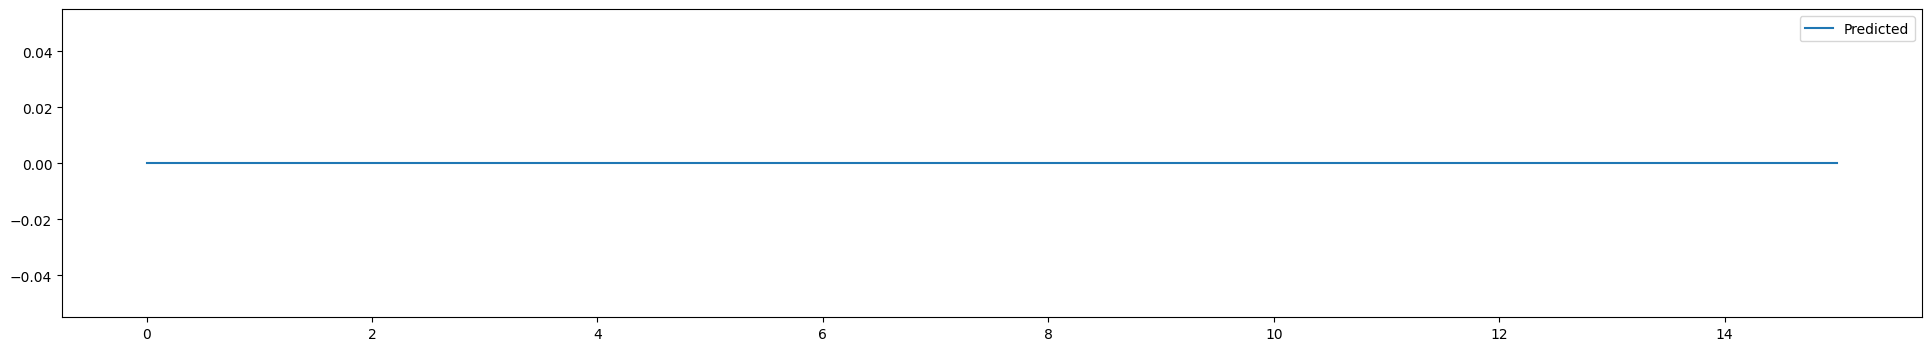

In [ ]:
y_newest_flat = np.argmax(y_newest.reshape(-1, y_newest.shape[-1]), axis=1)
plt.figure(figsize=(24, 4))
plt.plot(y_newest_flat, label='Predicted')
plt.legend()
plt.show()

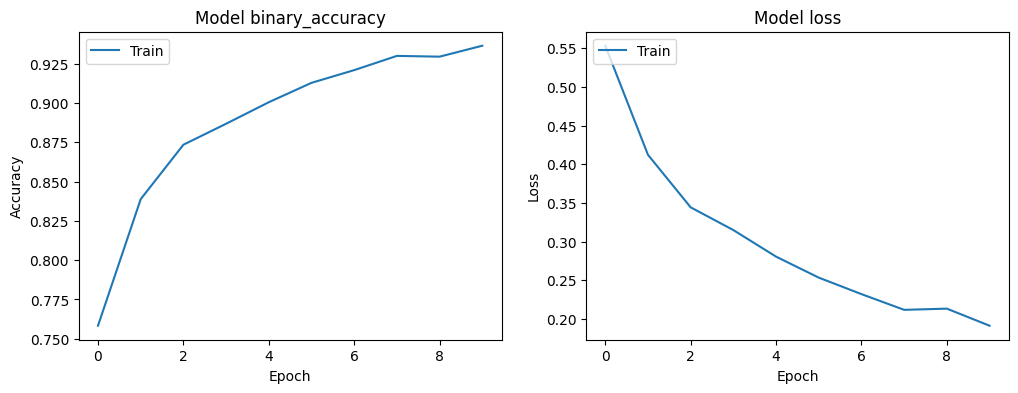

In [ ]:
# Function to plot training curves
def plot_training_curves(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['binary_accuracy'])
    # plt.plot(history.history['val_binary_accuracy'])
    plt.title('Model binary_accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    # plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
if history:
    # Plot the training curves
    plot_training_curves(history)

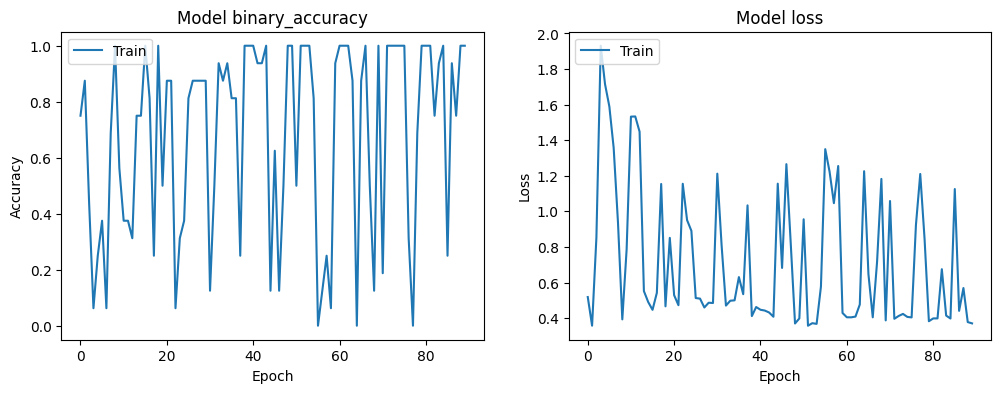

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(online_training_acc)
# plt.plot(val_acc)
plt.title('Model binary_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(online_training_losses)
# plt.plot(val_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# # Output the evaluation metrics
# print(f'Precision: {precision}')
# print(f'Recall: {recall}')
# print(f'Accuracy: {accuracy}')
# print(f'F1 Score: {f1}')


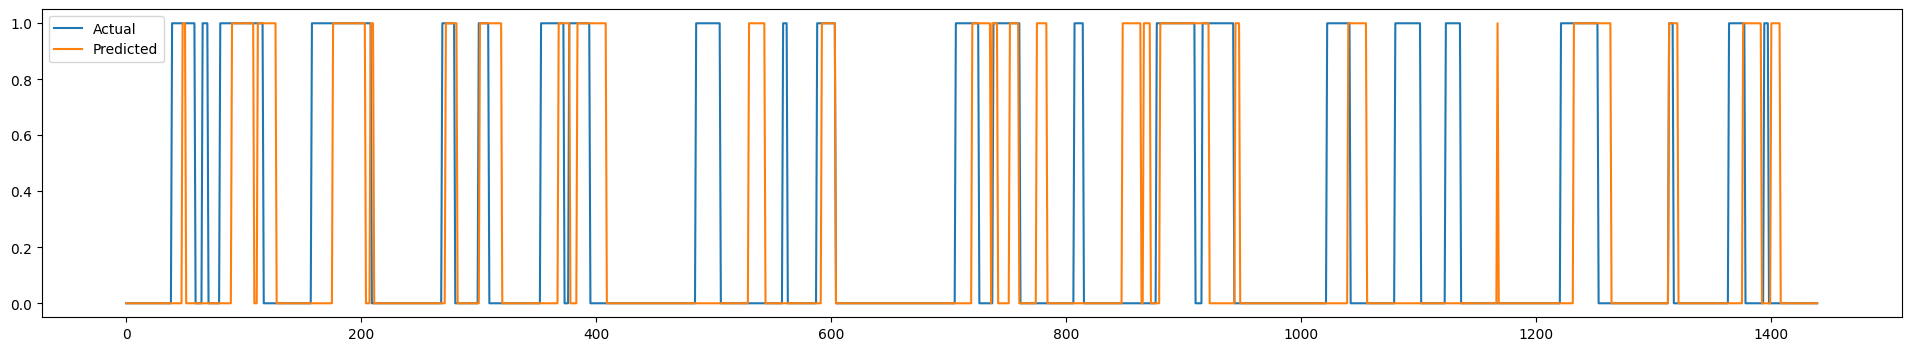

In [ ]:
y_test_flat = np.argmax(y_test.reshape(-1, y_test.shape[-1]), axis=1)
y_preds_flat = np.argmax(y_preds.reshape(-1, y_preds.shape[-1]), axis=1)
plt.figure(figsize=(24, 4))
plt.plot(y_test_flat, label='Actual')
plt.plot(y_preds_flat, label='Predicted')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

class Postprocesser:
    def __init__(self, threshold=0.5):
        self.threshold = threshold

    def process_signals(self, y_data, dates):
        # Step 1: Find the index of the maximum value along the last dimension
        max_indices = np.argmax(y_data, axis=-1)

        # Flatten the max_indices
        flatten_max_indices = max_indices.flatten()

        # Initialize an array for signals
        signals = np.full(flatten_max_indices.shape, '', dtype=object)

        # Identify transition points
        for i in range(1, len(flatten_max_indices)):
            if flatten_max_indices[i-1] == 1 and flatten_max_indices[i] == 0: # downward to upward 
                signals[i] = 'Buy'
            elif flatten_max_indices[i-1] == 0 and flatten_max_indices[i] == 1: # upward to downward
                signals[i] = 'Sell'

        # Flatten the dates
        flat_dates = dates.flatten()

        # Create DataFrame
        return pd.DataFrame({'Date': flat_dates, 'Signal': signals})


# Example usage
# Assuming y_data is your model output and dates is an array of dates corresponding to each prediction
postprocessor = Postprocesser()
test_trade_signals = postprocessor.process_signals(y_test, test_dates)
pred_trade_signals = postprocessor.process_signals(y_preds, test_dates)
# newest_trade_signals = postprocessor.process_signals(y_newest, y) # TODO: fix this

In [ ]:
# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3):
#     display(pred_trade_signals)


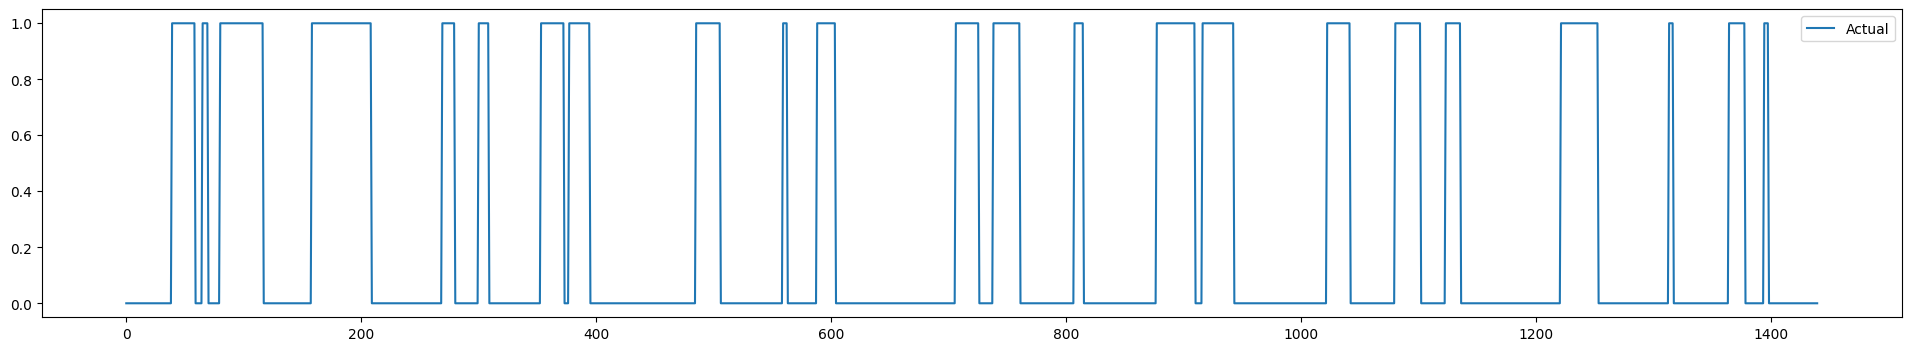

In [ ]:
y_test_flat = np.argmax(y_test.reshape(-1, y_test.shape[-1]), axis=1)
y_preds_flat = np.argmax(y_preds.reshape(-1, y_preds.shape[-1]), axis=1)
plt.figure(figsize=(24, 4))
plt.plot(y_test_flat, label='Actual')
# plt.plot(y_preds_flat, label='Predicted')
plt.legend()
plt.show()

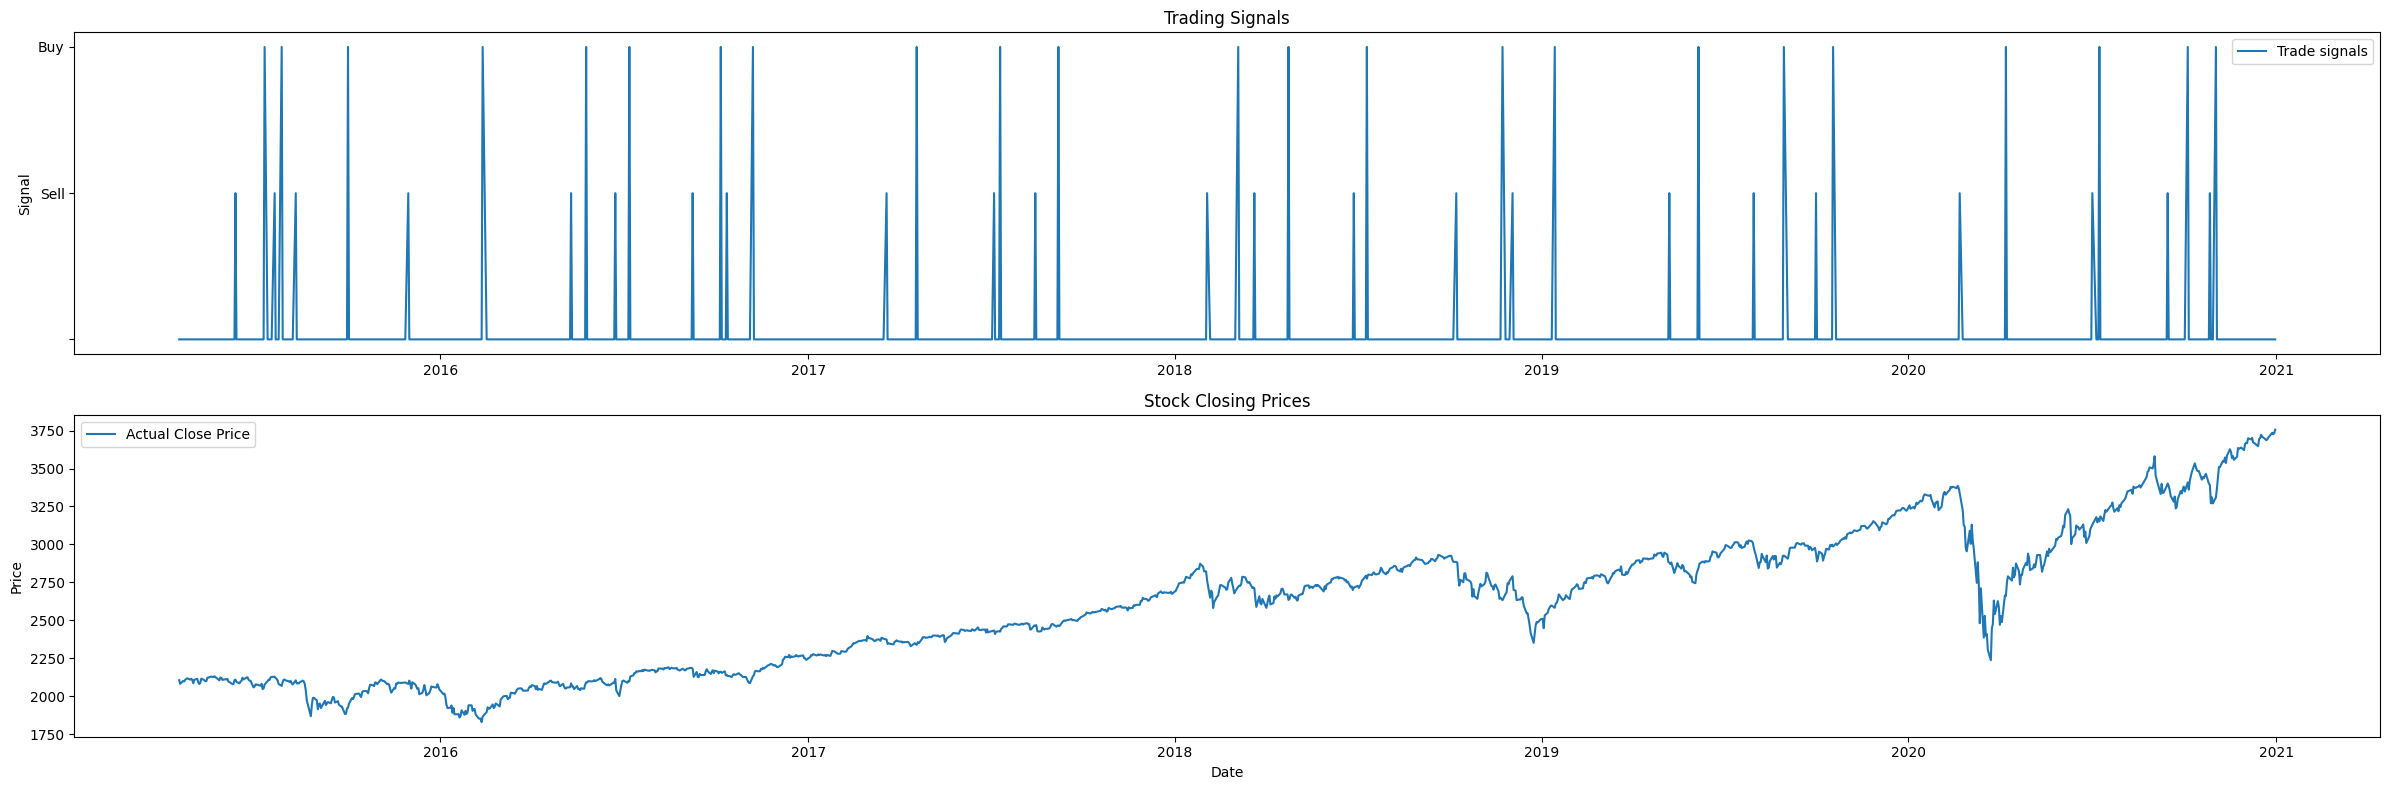

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 8))

# First subplot for signals
ax1.plot(test_trade_signals['Date'], test_trade_signals['Signal'], label='Trade signals')
# ax1.plot(model_data.data.loc[test_trade_signals['Date']]['Trend'], label='Trend')
ax1.legend()
ax1.set_title('Trading Signals')
ax1.set_ylabel('Signal')

# Second subplot for closing prices
ax2.plot(model_data.data.loc[test_trade_signals['Date']]['Close'], label='Actual Close Price')
ax2.legend()
ax2.set_title('Stock Closing Prices')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import backtrader as bt

class Evaluation:
    def __init__(self):
        pass

    def analyze_results(self, y_test, y_preds, history, online_training_acc, online_training_losses):
        # Confusion Matrix
        precision, recall, accuracy, f1 = self.confusion_matrix(y_preds, y_test)
        print(f'Average Precision: {precision}')
        print(f'Average Recall: {recall}')
        print(f'Average Accuracy: {accuracy}')
        print(f'Average F1 Score: {f1}')

        self.plot_confusion_matrix(y_test, y_preds)
        # Training Loss Curve
        if history:
            self.plot_loss_curve(history)
        # Online Training Loss Curve
        self.plot_online_training_curve(online_training_acc, online_training_losses)

    def confusion_matrix(self, y_preds, y_test):
        # Flatten the 3D tensors for evaluation
        y_test_flat = np.argmax(y_test.reshape(-1, y_test.shape[-1]), axis=1)
        y_preds_flat = np.argmax(y_preds.reshape(-1, y_preds.shape[-1]), axis=1)

        # Calculate evaluation metrics
        precision = precision_score(y_test_flat, y_preds_flat, average='macro')
        recall = recall_score(y_test_flat, y_preds_flat, average='macro')
        accuracy = accuracy_score(y_test_flat, y_preds_flat)
        f1 = f1_score(y_test_flat, y_preds_flat, average='macro')

        return precision, recall, accuracy, f1
    
    def plot_confusion_matrix(self, y_test, y_preds):
        # Convert to class labels if necessary
        y_test = np.argmax(y_test.reshape(-1, y_test.shape[-1]), axis=1)
        y_preds = np.argmax(y_preds.reshape(-1, y_preds.shape[-1]), axis=1)

        # Compute confusion matrix
        cm = confusion_matrix(y_test, y_preds)
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title('Confusion Matrix')

        # Calculate metrics
        recall = recall_score(y_test, y_preds, average='macro')
        accuracy = accuracy_score(y_test, y_preds)
        f1 = f1_score(y_test, y_preds, average='macro')

        # Annotate metrics on the plot
        plt.xlabel(f'Predicted\n\nAccuracy: {accuracy:.2f}\nF1 Score: {f1:.2f}')
        plt.ylabel(f'Actual\n\nRecall: {recall:.2f}')
        plt.show()

    def plot_loss_curve(self, history):
        # Plot training loss curve
        plt.plot(history.history['loss'])
        plt.title('Training Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.show()

    def plot_online_training_curve(self, acc, losses):
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

        # Plot accuracy on the first subplot
        ax1.plot(acc, color='tab:red')
        ax1.set_title('Online Training Accuracy')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Accuracy')
        ax1.grid(True)

        # Plot loss on the second subplot
        ax2.plot(losses, color='tab:blue')
        ax2.set_title('Online Training Loss')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Loss')
        ax2.grid(True)

        # Adjust the layout
        plt.tight_layout()
        plt.show()

    def perform_backtesting(self, stock_data, pred_trade_signals):
        # Initialize cerebro engine
        cerebro = bt.Cerebro()

        # Create a data feed from stock data
        data_feed = bt.feeds.PandasData(dataname=stock_data)

        # Add data feed to cerebro
        cerebro.adddata(data_feed)

        # Define and add strategy
        class SignalStrategy(bt.Strategy):
            def __init__(self):
                # Map dates to signals for quick lookup
                self.signal_dict = dict((pd.Timestamp(date).to_pydatetime().date(), signal)
                                        for date, signal in zip(pred_trade_signals['Date'], pred_trade_signals['Signal']))

            def next(self):
                # Get the current date
                current_date = self.datas[0].datetime.date(0)

                # Check if there's a signal for this date
                signal = self.signal_dict.get(current_date)

                # Implement your trading logic based on the signal
                if signal == 'Buy':
                    # Buy logic
                    self.buy()
                elif signal == 'Sell':
                    # Sell logic
                    self.sell()

        # Add strategy to cerebro
        # %matplotlib inline
        cerebro.addstrategy(SignalStrategy)

        # Set initial cash, commission, etc.
        cerebro.broker.setcash(10000.0)
        cerebro.broker.setcommission(commission=0.001)

        # # Run the backtest
        # results = cerebro.run()

        # You can add more code here to analyze the results
        # Add analyzers to cerebro
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio')
        cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
        cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')

        # Run the backtest
        strategies = cerebro.run()

        # Extracting and displaying results
        for strategy in strategies:
            print("Final Portfolio Value: ", strategy.broker.getvalue())
            print("Sharpe Ratio: ", strategy.analyzers.sharpe_ratio.get_analysis())
            print("Drawdown Info: ", strategy.analyzers.drawdown.get_analysis())
            print("Trade Analysis: ", strategy.analyzers.trade_analyzer.get_analysis())
        # Plotting the results
        # cerebro.plot(style='candlestick')

        return strategies
        return results


In [ ]:
# Initialize the evaluation class with the postprocessor
evaluator = Evaluation()

# Analyze the model's results
# evaluator.analyze_results(y_test, y_preds, history, online_training_acc, online_training_losses)

# Perform backtesting with the generated signals and historical stock data
backtest_results = evaluator.perform_backtesting(model_data.data, test_trade_signals)


Final Portfolio Value:  11414.774825927732
Sharpe Ratio:  OrderedDict([('sharperatio', -0.20300157270697347)])
Drawdown Info:  AutoOrderedDict([('len', 197), ('drawdown', 3.862030784387384), ('moneydown', 458.5515185546883), ('max', AutoOrderedDict([('len', 407), ('drawdown', 4.024738354454529), ('moneydown', 477.8703193359379)]))])
Trade Analysis:  AutoOrderedDict([('total', AutoOrderedDict([('total', 23), ('open', 0), ('closed', 23)])), ('streak', AutoOrderedDict([('won', AutoOrderedDict([('current', 0), ('longest', 4)])), ('lost', AutoOrderedDict([('current', 3), ('longest', 3)]))])), ('pnl', AutoOrderedDict([('gross', AutoOrderedDict([('total', 1533.110595703125), ('average', 66.656982421875)])), ('net', AutoOrderedDict([('total', 1414.7748259277346), ('average', 61.511948953379765)]))])), ('won', AutoOrderedDict([('total', 14), ('pnl', AutoOrderedDict([('total', 1602.9674025878908), ('average', 114.49767161342076), ('max', 566.6674973144532)]))])), ('lost', AutoOrderedDict([('tota

In [ ]:
for i in backtest_results:
    print(i.analyzers.trade_analyzer.get_analysis())

AutoOrderedDict([('total', AutoOrderedDict([('total', 23), ('open', 0), ('closed', 23)])), ('streak', AutoOrderedDict([('won', AutoOrderedDict([('current', 0), ('longest', 4)])), ('lost', AutoOrderedDict([('current', 3), ('longest', 3)]))])), ('pnl', AutoOrderedDict([('gross', AutoOrderedDict([('total', 1533.110595703125), ('average', 66.656982421875)])), ('net', AutoOrderedDict([('total', 1414.7748259277346), ('average', 61.511948953379765)]))])), ('won', AutoOrderedDict([('total', 14), ('pnl', AutoOrderedDict([('total', 1602.9674025878908), ('average', 114.49767161342076), ('max', 566.6674973144532)]))])), ('lost', AutoOrderedDict([('total', 9), ('pnl', AutoOrderedDict([('total', -188.19257666015622), ('average', -20.910286295572913), ('max', -77.62121118164063)]))])), ('long', AutoOrderedDict([('total', 0), ('pnl', AutoOrderedDict([('total', 0.0), ('average', 0.0), ('won', AutoOrderedDict([('total', 0.0), ('average', 0.0), ('max', 0.0)])), ('lost', AutoOrderedDict([('total', 0.0), (

In [ ]:
for strategy in backtest_results:
    print("Final Portfolio Value: ", strategy.broker.getvalue())
    print("Sharpe Ratio: ", strategy.analyzers.sharpe_ratio.get_analysis())
    print("Drawdown Info: ", strategy.analyzers.drawdown.get_analysis())
    print("Trade Analysis: ", strategy.analyzers.trade_analyzer.get_analysis())

Final Portfolio Value:  11414.774825927732
Sharpe Ratio:  OrderedDict([('sharperatio', -0.20300157270697347)])
Drawdown Info:  AutoOrderedDict([('len', 197), ('drawdown', 3.862030784387384), ('moneydown', 458.5515185546883), ('max', AutoOrderedDict([('len', 407), ('drawdown', 4.024738354454529), ('moneydown', 477.8703193359379)]))])
Trade Analysis:  AutoOrderedDict([('total', AutoOrderedDict([('total', 23), ('open', 0), ('closed', 23)])), ('streak', AutoOrderedDict([('won', AutoOrderedDict([('current', 0), ('longest', 4)])), ('lost', AutoOrderedDict([('current', 3), ('longest', 3)]))])), ('pnl', AutoOrderedDict([('gross', AutoOrderedDict([('total', 1533.110595703125), ('average', 66.656982421875)])), ('net', AutoOrderedDict([('total', 1414.7748259277346), ('average', 61.511948953379765)]))])), ('won', AutoOrderedDict([('total', 14), ('pnl', AutoOrderedDict([('total', 1602.9674025878908), ('average', 114.49767161342076), ('max', 566.6674973144532)]))])), ('lost', AutoOrderedDict([('tota